In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
from utils import parse_txt, plot3D, remove_outliers, get_3D_box
from ransac import get_inplane_point_idx, ransac
from rigid import translate, get_vector_normal, get_rotation_matrix, rotate

In [2]:
txt = './home/points3D.txt'
data = parse_txt(txt)
print(data.shape)

(30624, 3)


### Remove extreme outliers

In [3]:
data = remove_outliers(data, 4)
print(data.shape)

# outlier points: (79, 3)
# inlier points: (30545, 3)
(30545, 3)


### Run RANSAC to find dominant plane

In [4]:
sample_size = 3
num_iters = 20
threshold_inlier = 0.01
num_points = 1000
best_model, best_count = ransac(data, sample_size, num_iters, threshold_inlier, num_points)
print('best fit:', best_model, best_count)

iter 0: model param [-0.08256093 -0.06126095 -0.12513755  0.98679855], in plane point count 891
iter 1: model param [ 0.02842534 -0.05476793 -0.10446817  0.99261215], in plane point count 2763
iter 2: model param [ 0.25379892  0.00628301 -0.15136865  0.95531888], in plane point count 549
iter 3: model param [-0.0046159  -0.12969446 -0.09427173  0.98705161], in plane point count 12058
iter 4: model param [-0.03467874  0.62831877 -0.04866285 -0.77565768], in plane point count 249
iter 5: model param [ 0.06614576 -0.07048173 -0.1088351   0.98934927], in plane point count 2135
iter 6: model param [ 0.01327461 -0.06034025 -0.114907    0.99145309], in plane point count 2689
iter 7: model param [ 0.02143186 -0.13985322 -0.09440671  0.9854284 ], in plane point count 2637
iter 8: model param [-0.00278442 -0.13541988 -0.09311328  0.98639932], in plane point count 18961
iter 9: model param [-0.00252908 -0.13725929 -0.09273454  0.98618142], in plane point count 18748
iter 10: model param [ 0.05057

In [5]:
inplane_point_idx = get_inplane_point_idx(best_model, data, threshold_inlier)
inplane_points = data[inplane_point_idx, :]
print('# inplane points:', inplane_points.shape)

mask = np.ones(len(data), np.bool)
mask[inplane_point_idx] = 0
outplane_points = data[mask]
print('# outplane points:', outplane_points.shape)

# inplane points: (18965, 3)
# outplane points: (11580, 3)


### XYZ coordinates

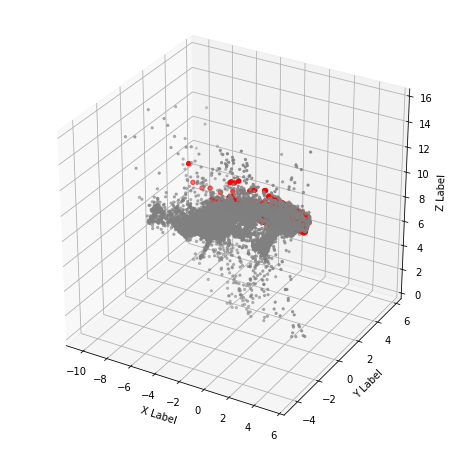

In [6]:
%matplotlib notebook
plot3D(inplane_points, outplane_points, plot_plane=False)

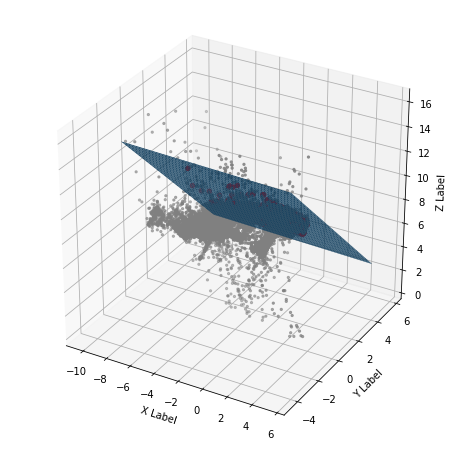

In [7]:
%matplotlib notebook
plot3D(inplane_points, outplane_points, plot_plane=True, model=best_model)

### Compute rotation matrix

In [8]:
center_XYZ = np.mean(inplane_points, axis=0)
center_XYZ = center_XYZ.reshape(1, 3)
inplane_points_centered = translate(inplane_points, -center_XYZ)
outplane_points_centered = translate(outplane_points, -center_XYZ)

In [9]:
normal_XYZ = get_vector_normal(best_model)
normal_xyz = np.array([0, 0, 1])

In [10]:
# R_xyz2XYZ = get_rotation_matrix(normal_xyz, normal_XYZ)
R_XYZ2xyz = get_rotation_matrix(normal_XYZ, normal_xyz)

In [11]:
inplane_points_local = rotate(inplane_points_centered, R_XYZ2xyz)
outplane_points_local = rotate(outplane_points_centered, R_XYZ2xyz)

### Local xyz coordinates

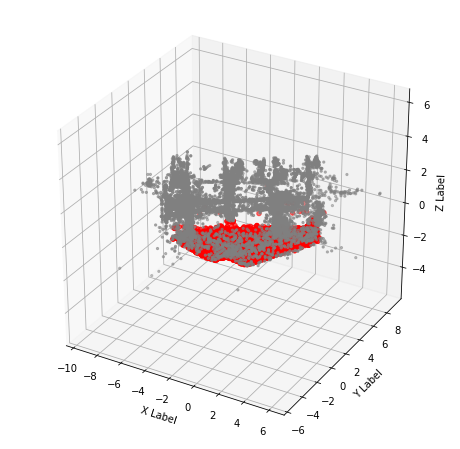

In [12]:
%matplotlib notebook
plot3D(inplane_points_local, outplane_points_local, plot_plane=False)

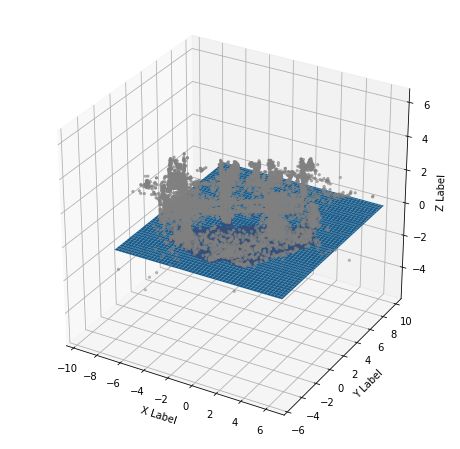

In [13]:
%matplotlib notebook
plot3D(inplane_points_local, outplane_points_local, plot_plane=True, model=np.array([0, 0, 1, 0]))

### Put a 3D box in local xyz coordinates

In [19]:
dimx, dimy, dimz = 3, 3, 1 # box dimension along axis
corners_local = get_3D_box(dimx, dimy, dimz)

<IPython.core.display.Javascript object>


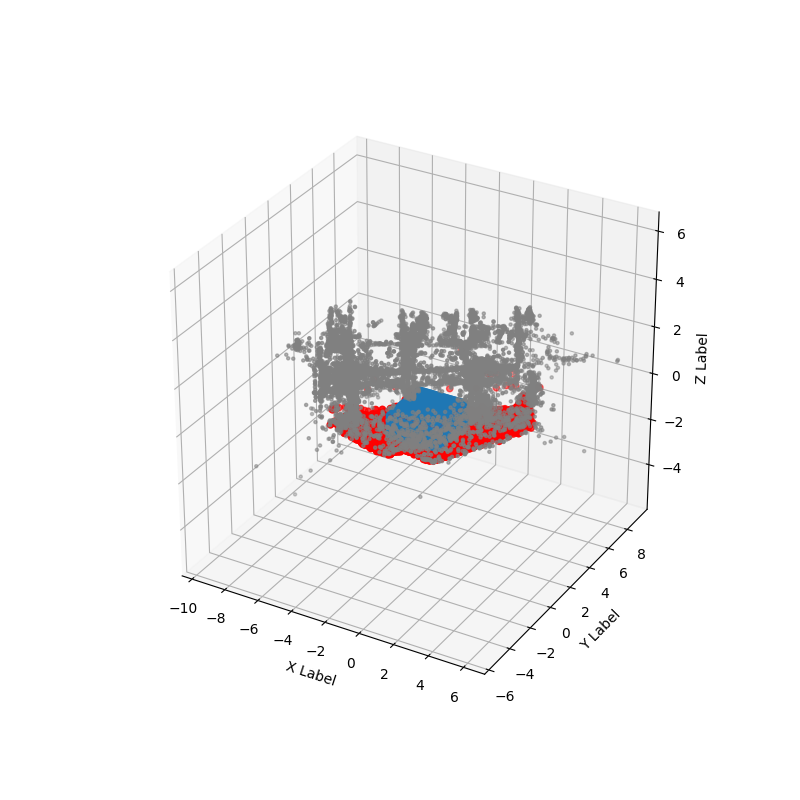

In [20]:
%matplotlib notebook
plot3D(inplane_points_local, outplane_points_local, plot_box=True, corners=corners_local)

### Convert local 3D box back to scene XYZ coordinates

In [21]:
R_xyz2XYZ = get_rotation_matrix(normal_xyz, normal_XYZ)
corners = rotate(corners_local, R_xyz2XYZ)
corners = translate(corners, center_XYZ)

<IPython.core.display.Javascript object>


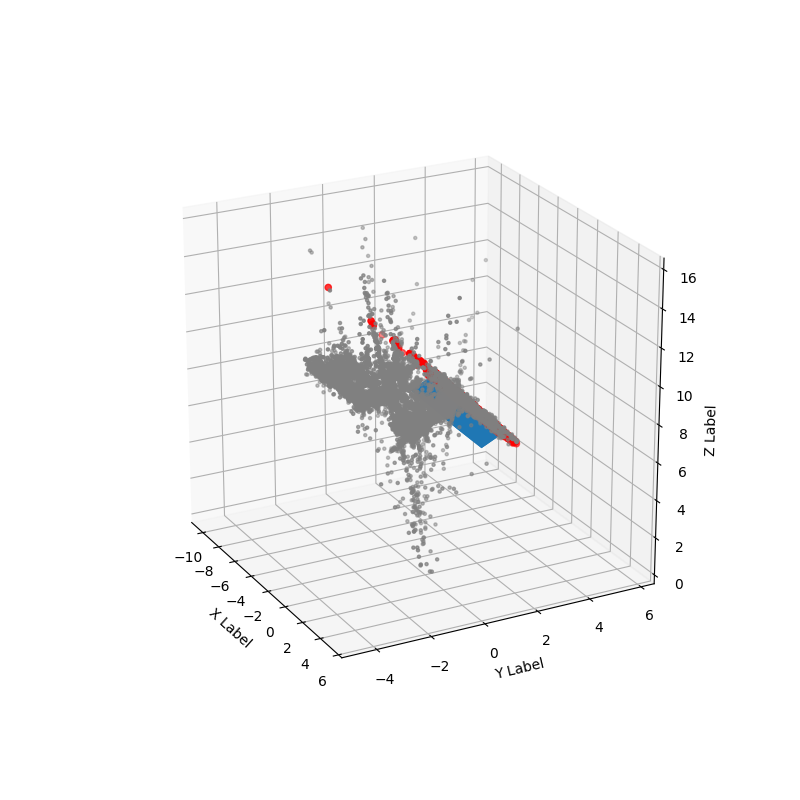

In [22]:
%matplotlib notebook
plot3D(inplane_points, outplane_points, plot_box=True, corners=corners)